# Lógica Computacional 21/22

## Trabalho Prático 4

ID: Pergunta 1 - Grupo 1

Equipa:

1. Alef Keuffer (A91683)
2. Alexandre Rodrigues Baldé (A70373)

## Preparação do código

### Dependências

In [37]:
%pip install pysmt numpy matplotlib

from pysmt.shortcuts import *
from pysmt.typing import *
import numpy as np
import timeit
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Enunciado do problema

#### Python Anotado

Considere o seguinte programa, em Python anotado, para multiplicação de dois inteiros de precisão limitada a 16 bits.

```python
        assume m >= 0 and n >= 0 and r == 0 and x == m and y == n 
    0: while y > 0:
    1:    if y & 1 == 1: 
                y , r  = y-1 , r+x
    2:    x , y = x<<1  ,  y>>1
    3: assert r == m * n
```

1. Prove por indução a terminação deste programa
$$\,$$
2. Pretende-se verificar a correção total deste  programa usando a metodologia dos invariantes e a metodologia do “single assignment unfolding”. Para isso, 
    1. Codifique usando a LPA (linguagem de programas anotadas) a forma recursiva deste programa. 
    2. Proponha o invariante mais fraco que assegure a correção, codifique-o em SMT e prove a correção.
    3. Construa a definição iterativa do “single assignment unfolding”  usando um parâmetro limite $$\,N\,$$  e aumentando a pré-condição com a condição 
                                            $$(n < N)\,\land\,(m<N)$$
        O número de iterações vai ser controlado por este parâmetro $$N$$

# Pergunta 1

## FOTS para o programa anotado

Construa-se um FOTS que modela o programa anotado do enunciado, de forma a utilizar-se $k$-indução para provar a sua terminação.
  
Considerem-se as variáveis $x,y,r,m,n$ parte do FOTS, assim como uma variável $pc$ que indica a que instrução em que a execução do programa está num dado momento.
  
Defina-se agora a função que declara as variáveis do FOTS:

### Variáveis e estado inicial do FOTS

In [4]:
word_len = 16

BV16 = BVType(word_len)

def declare(i):
    state = {}
    
    state['x'] = Symbol('x'+str(i), BV16)
    state['y'] = Symbol('y'+str(i), BV16)
    state['r'] = Symbol('r'+str(i), BV16)
    state['m'] = Symbol('m'+str(i), BV16)
    state['n'] = Symbol('n'+str(i), BV16)
    state['pc'] = Symbol('pc'+str(i), INT)
    
    return state

---
#### Funções auxiliares

O PySMT não permite comparação entre vetores de bits e inteiros, logo a função abaixo é necessária para o fazer.

In [5]:
def bitVecIntComp(vec, i, bin_op, size = word_len):
    intVec = BV(i, size)
    if i == 0:
        intVec = BVZero(size)
    elif i == 1:
        intVec = BVOne(size)
    if bin_op == "EQ":
        return Equals(vec, intVec)
    elif bin_op == "NEQ":
        return Equals(vec, intVec)
    elif bin_op == "GT":
        return BVUGT(vec, intVec)
    elif bin_op == "GE":
        return BVUGE(vec, intVec)
    elif bin_op == "LT":
        return BVULT(vec, intVec)
    elif bin_op == "LE":
        return BVULE(vec, intVec)
    raise ValueError("Wrong operator supplied to helper function bitVecIntComp!")

---

O predicado que define o estado inicial do FOTS é

$$
pc = 0 \land m \ge 0 \land n \ge 0 \land r = 0 \land x = m \land y = n 
$$

Este predicado deriva da pre-condição do programa.
  
Note-se que, para resolver este problema, se consideram $m, n \ge 0$, ou seja, está-se a trabalhar no anel $\mathbb{Z}_{2^{16}}$, e havendo overflow, interpreta-se o resultado dessa forma.

In [6]:
def init(state):
    l = []

    l.append(bitVecIntComp(state['m'], 0, "GE"))
    l.append(bitVecIntComp(state['n'], 0, "GE"))
    l.append(bitVecIntComp(state['r'], 0, "EQ"))
    l.append(Equals(state['x'], state['m']))
    l.append(Equals(state['y'], state['n']))
    l.append(Equals(state['pc'], Int(0)))

    return And(l)

### Função de transição

#### $pc = 0$
Quando a variável $pc$ tem o valor $0$, o programa está no ciclo, e há duas possibilidades:
  - permanecer dentro do ciclo caso a condição seja verdadeira, ou
  - transitar para o fim do programa caso a condição seja falsa.

Isto corresponde aos predicados:

* $pc = 0 \land y \gt 0 \land y' = y \land m' = m \land r' = r \land x' = x \land n' = n \land pc'= 1$
  
e
  
* $pc = 0 \land y \le 0 \land y' = y \land m' = m \land r' = r \land x' = x \land n' = n \land pc' = 3$

---

#### $pc = 1$
Quando o valor de $pc$ é $1$, entrou-se dentro do ciclo.\
A próxima instrução é um `if_then_else`, donde:
* a condição é verdadeira e as variáveis $y$ e $r$ são alteradas, ou então
* a condição é falsa e as variáveis $y$ e $r$ não são alteradas.
  
Daqui, os seguintes predicados:

*
$$
pc = 1 \land \quad y \& 1 = 1 \quad \land \quad y' = y - 1 \quad \land \quad m' = m \quad \land \quad r' = r + x \quad \land 
$$

$$
\quad x' = x \quad \land \quad n' = n \quad \land \quad pc' = 2
$$
  
e
  
*
$$
pc = 1 \quad \land \quad \neg(y \quad \& \quad 1 = 1) \quad \land \quad y' = y \quad \land \quad m' = m \quad \land \quad r' = r \quad \land 
$$
$$ 
\quad x' = x \quad \land \quad n' = n \quad \land \quad pc' = 2
$$

---

#### $pc = 2$
Quando $pc = 2$, termina-se a execução do corpo do ciclo, e volta-se a $pc = 0$, para re-executar o ciclo se a condição se verificar.

$$
pc = 2 \land y' = y >> 1 \land m' = m \land r' = r \land x' = x << 1 \land n' = n \land pc' = 0
$$

---

#### $pc = 3$
Este caso correspondo à transição do estado final para ele próprio:

$$
pc = 3 \land y' = y \land m' = m \land r' = r \land x' = x \land n' = n \land pc' = 3
$$

Note-se o uso da função `bitVecIntComp` para fazer as comparações entre `INT`s de PySMT e `BVType(16)`.

In [7]:
def trans(curr, prox):
    l = []

    state1 = [Equals(curr['pc'], Int(0)),
              bitVecIntComp(curr['y'], 0, "GT"),
              Equals(prox['y'], curr['y']),
              Equals(prox['m'], curr['m']),
              Equals(prox['r'],  curr['r']),
              Equals(prox['x'], curr['x']),
              Equals(prox['n'], curr['n']),
              Equals(prox['pc'], Int(1))]
    l.append(And(state1))

    state2 = [Equals(curr['pc'], Int(0)),
             bitVecIntComp(curr['y'], 0, "LE"),
             Equals(prox['y'], curr['y']),
             Equals(prox['m'], curr['m']),
             Equals(prox['r'],  curr['r']),
             Equals(prox['x'], curr['x']),
             Equals(prox['n'], curr['n']),
             Equals(prox['pc'], Int(3))]
    l.append(And(state2))

    state3 = [Equals(curr['pc'], Int(1)),
             Equals(BVAnd(curr['y'], BVOne(word_len)), BVOne(word_len)),
             Equals(prox['y'], BVSub(curr['y'], BVOne(word_len))),
             Equals(prox['r'],  BVAdd(curr['r'], curr['x'])),
             Equals(prox['x'], curr['x']),
             Equals(prox['m'], curr['m']),
             Equals(prox['n'], curr['n']),
             Equals(prox['pc'], Int(2))]
    l.append(And(state3))

    state4 = [Equals(curr['pc'], Int(1)),
              NotEquals(BVAnd(curr['y'], BVOne(word_len)), BVOne(word_len)),
              Equals(prox['y'], curr['y']),
              Equals(prox['r'], curr['r']),
              Equals(prox['x'], curr['x']),
              Equals(prox['m'], curr['m']),
              Equals(prox['n'], curr['n']),
              Equals(prox['pc'], Int(2))]
    l.append(And(state4))

    state5 = [Equals(curr['pc'], Int(2)),
              Equals(prox['x'], BVLShl(curr['x'], BVOne(word_len))),
              Equals(prox['y'], BVLShr(curr['y'], BVOne(word_len))),
              Equals(prox['m'], curr['m']),
              Equals(prox['n'], curr['n']),
              Equals(prox['r'], curr['r']),
              Equals(prox['pc'], Int(0))]
    l.append(And(state5))

    state6 = [Equals(curr['pc'], Int(3)),
              Equals(prox['y'], curr['y']),
              Equals(prox['m'], curr['m']),
              Equals(prox['r'], curr['r']),
              Equals(prox['x'], curr['x']),
              Equals(prox['n'], curr['n']),
              Equals(prox['pc'], Int(3))]
    l.append(And(state6))
    
    return Or(l)

### Geração de traço de execução

Como se viu nas aulas Teórico-Práticas, a função abaixo gera um traço de execução do FOTS.

In [8]:
def gera_traco(declare,init,trans,k):
    trace = [declare(i) for i in range(k)]
    s = Solver(name = 'z3')
    s.reset_assertions()

    s.add_assertion(init(trace[0]))

    for i in range(k-1):
        s.add_assertion(trans(trace[i], trace[i + 1]))

    r = s.solve()
    if r: # s is SAT
        m = s.get_model()
        for i in range(k):
            print(f"state {i}:")
            for v in trace[i]:
                print(v, ' = ', s.get_value(trace[i][v]))
        return
    
    print('UNSAT!')
    return

gera_traco(declare, init, trans, 20)

state 0:
x  =  256_16
y  =  55_16
r  =  0_16
m  =  256_16
n  =  55_16
pc  =  0
state 1:
x  =  256_16
y  =  55_16
r  =  0_16
m  =  256_16
n  =  55_16
pc  =  1
state 2:
x  =  256_16
y  =  54_16
r  =  256_16
m  =  256_16
n  =  55_16
pc  =  2
state 3:
x  =  512_16
y  =  27_16
r  =  256_16
m  =  256_16
n  =  55_16
pc  =  0
state 4:
x  =  512_16
y  =  27_16
r  =  256_16
m  =  256_16
n  =  55_16
pc  =  1
state 5:
x  =  512_16
y  =  26_16
r  =  768_16
m  =  256_16
n  =  55_16
pc  =  2
state 6:
x  =  1024_16
y  =  13_16
r  =  768_16
m  =  256_16
n  =  55_16
pc  =  0
state 7:
x  =  1024_16
y  =  13_16
r  =  768_16
m  =  256_16
n  =  55_16
pc  =  1
state 8:
x  =  1024_16
y  =  12_16
r  =  1792_16
m  =  256_16
n  =  55_16
pc  =  2
state 9:
x  =  2048_16
y  =  6_16
r  =  1792_16
m  =  256_16
n  =  55_16
pc  =  0
state 10:
x  =  2048_16
y  =  6_16
r  =  1792_16
m  =  256_16
n  =  55_16
pc  =  1
state 11:
x  =  2048_16
y  =  6_16
r  =  1792_16
m  =  256_16
n  =  55_16
pc  =  2
state 12:
x  =  4096_16

### Prova de terminação do programa

Utilize-se $k$-lookahead para provar a terminação do programa acima, que é uma propriedade da forma $F (G\ \phi)$, onde $\phi \equiv pc = 3$.
  
É necessário encontrar um variante $V$ que satisfaça as seguintes condições, descritas na folha de exercícios 7 das aulas Teórica-Práticas:

1. O variante é positivo ou nulo: $G\ (V(s) \ge 0)$
2. O variante é estritamente decrescente, ou atinge o valor 0, ou seja,
  * $G\ (\forall s'\ .\ \mathit{trans}(s,\ s') \rightarrow (V(s') < V(s) \lor V(s') = 0))$
3. Quando o variante é 0 verifica-se necessariamente $\phi$, ou seja, $G\ (V(s)=0 \rightarrow \phi(s))$

Considerando-se o uso de $k$-lookahead, a $2º$ condição pode ser alargada, permitindo-se que o variante decresça necessariamente de $3$ em $3$ transições, e não necessariamente em transições consecutivas.

#### *Lookahead*
  
O lookahead em causa é de $3$, que é o número mínimo de instruções necessárias para que $pc$ vá do [início ao fim do ciclo](#python-anotado).

---

Utilize-se o seguinte variante:

$$
V(s) \equiv (y_{s} - pc_{s}) + 3
$$

Antes de proceder à prova de terminação com este variante, algumas notas sobre esta escolha:
1. $pc_s$, durante a execução do ciclo, é tal que $0 \le pc_s \le 2$
2. $y_s$, durante a execução do ciclo, é tal que $y_s \gt 0 \Leftrightarrow y_s \ge 1$
3. $y_s - pc_s$, durante a execução do ciclo, é tal que $y_s - pc_s \ge -1$
4. Conclui-se que, durante a execução do ciclo, $(y_s - pc_s) + 3 \ge 2 \gt 0$

Após a execução do ciclo:
* $pc_s = 3 \Leftrightarrow \text{o ciclo terminou}$
* $\text{o ciclo terminou} \Rightarrow y_s \le 0$

Tendo em conta que $y$ sofre um *shift* para a esquerda de 1 bit em cada iteração do ciclo, tem-se necessariamente que na última iteração do ciclo $y_s = 1$, e após essa execução final do corpo do ciclo, $y_s$ será então 0,
donde

$$
\begin{align*}
(y_s - pc_s) + 3 & = -pc_s + 3 \quad (y_s = 0)\\
    & = -3 + 3 \quad (\text{terminou-se o ciclo, donde } pc_s = 3)\\
    & = 0 \\
    & \ge 0
\end{align*}
$$

#### Função para $k$-indução, e definição do variante:

In [9]:
def variante(state):
    return Plus(Minus(BVToNatural(state['y']), state['pc']), Int(3))

In [10]:
def kinduction_always(declare, init, trans, inv, k, solvers = ["z3"]):
    trace = [declare(i) for i in range(k + 1)]
    with Portfolio(solvers,
               logic="QF_BV",
               incremental=False,
               generate_models=False) as s:
        s.reset_assertions()
        s.add_assertion(init(trace[0]))
        for i in range(k - 1):
            s.add_assertion(trans(trace[i],trace[i + 1]))

        l = [Not(inv(trace[i])) for i in range(k)]

        s.add_assertion(Or(l))

        r = s.solve()

        if r:
            print('A prova por k-indução falhou no caso base:')
            print('O estado do FOTS que causou a falha:')
            m = s.get_model()
            for i in range(k):
                print(i)
                for v in trace[i]:
                    print(v, ' = ', m[trace[i][v]])
            return

        s.reset_assertions()
        for i in range(k):
            s.add_assertion(trans(trace[i],trace[i + 1]))
            s.add_assertion(inv(trace[i]))
        s.add_assertion(Not(inv(trace[k])))

        r = s.solve()

        if r:
            print(f'Falhou no passo de {k}-indução!')
            m = s.get_model()
            for i in range(k):
                print(i)
                for v in trace[i]:
                    print(v, ' = ', m[trace[i][v]])
            return

        if not r:
            print(f'Verifica-se a propriedade {inv}')
            return

Observe-se o uso de [`Portfolio`](https://pysmt.readthedocs.io/en/latest/api_ref.html#pysmt.shortcuts.Portfolio) para a criação de um `solver` que pode usar várias bibliotecas SMT em simultâneo.  
Permite também especificar explicitamente a lógica a ser usada por todos os *solvers*, neste caso `QF_BV`.

---

Primeiro, prove-se a propriedade 1.: $V$ é sempre positivo:

In [11]:
def positivo(state):
    prop = GE(variante(state), Int(0))
    return prop

kinduction_always(declare, init, trans, positivo, 3, ["z3", "msat", "bdd"])

Verifica-se a propriedade <function positivo at 0x7f4b72804430>


---
Agora, a segunda condição:

In [12]:
def decresce(state):
    state1 = declare(-1)
    state2 = declare(-2)
    state3 = declare(-3)
    varnames = list(state1.values()) + list(state2.values()) + list(state3.values())

    return ForAll(
        varnames,
        Implies(
            And(trans(state, state1),
                trans(state1, state2),
                trans(state2, state3)
            ),
            Or(LT(variante(state3), variante(state)),
               Equals(variante(state3), Int(0))
            )
        )
    )

kinduction_always(declare, init, trans, decresce, 3)

Verifica-se a propriedade <function decresce at 0x7f4b72522ef0>


---
Finalmente, a terceira condição: que o variante ser zero implica a chegada à última instrução:

In [13]:
def terminaçao(state):
    return Implies(Equals(variante(state), Int(0)), Equals(state['pc'], Int(3)))

kinduction_always(declare, init, trans, terminaçao, 3, ["z3", "msat", "bdd"])

Verifica-se a propriedade <function terminaçao at 0x7f4b72522d40>


---

# Pergunta 2

## Alínea a) Forma recursiva do programa em LPA

Recorde-se o programa original:

```python
        assume m >= 0 and n >= 0 and r == 0 and x == m and y == n 
    0: while y > 0:
    1:    if y & 1 == 1: 
                y , r  = y-1 , r+x
    2:    x , y = x<<1  ,  y>>1
    3: assert r == m * n
```

Seja $W$ o seguinte programa em linguagem de anotações.

$$
W \equiv \{\text{assume}\, (y \ge 0);\, S;\, W\} \quad || \quad \{\text{assume}\, \neg (y \ge 0)\}
$$

onde $S$ é o fluxo que corresponde à tradução da instrução dentro do ciclo para a linguagem de anotações:

```python
if (y & 1 == 1):
    y, r = y - 1, r + x;
x = x << 1;
y = y >> 1;
```

equivale a

```python
({
    assume (y & 1 == 1);
    y = y - 1;
    r = r + x;
} ||
{
    assume not (y & 1 == 1);
    skip;
})
x = x << 1;
y = y >> 1;
```

Logo o triplo de Hoare que especifica o programa na sua forma recursiva é:

$\phi \equiv$ `assume m >= 0 and n >= 0 and r == 0 and x == m and y == n;`  

$\varphi \equiv$ `assert r == m * n;`

$H \equiv \{\text{assume} \, \phi; W; \text{assume} \, \varphi\};$

onde $W$ equivale ao seguinte programa:
```python
{
    assume (y > 0);
    {
        assume (y & 1 == 1);
        y = y - 1;
        r = r + x;
    } ||
    {
        assume not (y & 1 == 1);
        skip;
    }
    x = x << 1;
    y = y >> 1;
    W
} ||
{
    assume not (y > 0);
}
```

---

## Alínea b) Invariante de ciclo, codificação em SMT e prova de correção

Considere-se o seguinte invariante:

$\theta \equiv (m \cdot n = x \cdot y + r) \land y \ge 0$

Analise-se a ideia do programa para explicá-lo.

Dados $m, n$, o programa coloca em $r$ o valor $m \cdot n$, e fá-lo da seguinte forma:
* Considere-se o número $n$ na sua representação binária, $n = \sum_{i = 0}^{n} b_i \cdot 2^i$, onde $b_i$ tem o valor do $i$-ésimo bit de $n$.
* Logo, $m \cdot n = m \cdot \sum_{i = 0}^{n} b_i \cdot 2^i = \sum_{i = 0}^{n} m \cdot b_i \cdot 2^i$
  Daí as instruções do ciclo
  ```python
  if y & 1 == 1: 
      y, r = y - 1, r + x
  x, y = x << 1, y >> 1
  ```
  Após cada iteração do ciclo $x$ sofre um *shift* para a esquerda (duplicando o seu valor), e se a condição se verificar -
  o $i$-ésimo bit de $y$ for 1 - acrescenta-se o valor de $m \cdot 2^i$ ao resultado $r$.

Veja-se o código em execução para exemplicar:

In [14]:
def mul(m, n):
    r = 0
    x = m
    y = n
    def prnt(): print(f"x: {x}; y: {y}; y (bin): {format(y, 'b')}; r: {r}; x*y + r = {x*y + r}")
    prnt()
    while y > 0:
        if y & 1 == 1: 
            y , r  = y-1 , r+x
        x , y = x<<1  ,  y>>1
        prnt()
    return r, m * n

mul(7, 136)

x: 7; y: 136; y (bin): 10001000; r: 0; x*y + r = 952
x: 14; y: 68; y (bin): 1000100; r: 0; x*y + r = 952
x: 28; y: 34; y (bin): 100010; r: 0; x*y + r = 952
x: 56; y: 17; y (bin): 10001; r: 0; x*y + r = 952
x: 112; y: 8; y (bin): 1000; r: 56; x*y + r = 952
x: 224; y: 4; y (bin): 100; r: 56; x*y + r = 952
x: 448; y: 2; y (bin): 10; r: 56; x*y + r = 952
x: 896; y: 1; y (bin): 1; r: 56; x*y + r = 952
x: 1792; y: 0; y (bin): 0; r: 952; x*y + r = 952


(952, 952)

Note-se que:
1. Antes da primeira iteração do ciclo, pela pré condição do programa, $x = m$, $y = n$, e $r = 0$, pelo que ele e válido.
2. Após a execução do ciclo, como se viu no caso do variante, tem-se que $y = 0$, pelo que o invariante também se mantém.

---

### Codificação das VCs em PySMT, e prova de validade

In [15]:
x = Symbol('x', BV16)
y = Symbol('y', BV16)
r = Symbol('r', BV16)
m = Symbol('m', BV16)
n = Symbol('n', BV16)

def prove(f):
    with Portfolio(
        ["z3"],
        logic="QF_BV",
        incremental=False,
        generate_models=False) as s:

        s.reset_assertions()
        s.add_assertion(Not(f))
        res = s.solve()
        if not res:
            print("The formula is a tautology!")
        elif res:
            print(is_sat(Not(f)))
            print("The formula is invalid!")
            print("Failing state:")
            print(s.get_model())
            print(f"x : {s.get_value(x)}")
            print(f"y : {s.get_value(y)}")
            print(f"r : {s.get_value(r)}")
            print(f"m : {s.get_value(m)}")
            print(f"n : {s.get_value(n)}")

Das fichas práticas, recorde-se que as condições de verificação de um programa com ciclo são:

$$
\frac{\{\phi\}{\sf skip} \{\theta\} \quad \{\theta \wedge b\} C \{\theta\} \quad \{\theta \wedge \neg b\}{\sf skip} \{\psi\} }{\{\phi\} {\sf while} \; b \;{\sf do } \;C \{\psi\}}
$$

Já se viu acima o corpo do ciclo traduzido para a linguagem de anotações na versão recursiva do programa.
Agora, para poder provar a segunda regra, coloca-se as pré e pós-condições, que envolvem o invariante e condição de ciclo

```python
assume (m * n = x * y + r and y >= 0) and (y > 0)
({
    assume (y & 1 == 1);
    y = y - 1;
    r = r + x;
} ||
{
    assume not (y & 1 == 1);
    skip;
})
x = x << 1;
y = y >> 1;
assert (m * n = x * y + r and y >= 0)
```

Utilizando as seguintes regras WPC para a geração de VCs:

\begin{array}{l}
[{\sf skip}] = True \\
[{\sf assume}\:\phi] = True \\
[{\sf assert}\:\phi] = \phi \\
[ x = e ] = True \\
[(C_1 || C_2)] = [C_1] \wedge [C_2] \\
\\
[{\sf skip}\, ; C] = [C] \\
[{\sf assume}\:\phi\, ; C] = \phi \to [C] \\
[{\sf assert}\:\phi\, ; C] = \phi \wedge [C] \\
[ x = e \, ; C] = [C][e/x] \\
[(C_1 || C_2)\, ; C] = [(C_1 ; C) || (C_2 ; C)]
\end{array}



Tem-se:

$(\theta \land (y \gt 0)) \rightarrow [(C_1 ; C)] \land [(C_2 ; C)]$

onde $\theta \equiv (m \cdot n = x \cdot y + r) \land y \ge 0$ é o invariante descrito acima, $C_1, C_2, C$ são os programas

```python
assume (y & 1 == 1);
y = y - 1;
r = r + x;
```
e
```python
assume not (y & 1 == 1);
skip;
```

```python
x = x << 1;
y = y >> 1;
assert (m * n == x * y + r and y >= 0)
```
, respetivamente.

---

No caso de $ [(C_1 ; C)]$, fica-se com a VC

```python
[assume (y & 1 == 1);
y = y - 1;
r = r + x;
x = x << 1;
y = y >> 1;
assert (m * n == x * y + r and y >= 0)]

== (y & 1 == 1) -> [y = y - 1;
                    r = r + x;
                    x = x << 1;
                    y = y >> 1;
                    assert (m * n == x * y + r and y >= 0)]

== (y & 1 == 1) -> (m * n == x * y + r and y >= 0)[y - 1 / y][r + x / r][x << 1 / x][y >> 1 / y]

== (y & 1 == 1) -> (m * n == (x << 1) * ((y >> 1) - 1) + (r + x) and ((y >> 1) - 1) >= 0)
```

---

No caso de $ [(C_2 ; C)]$, fica-se com a VC

```python
[assume not (y & 1 == 1);
skip;
x = x << 1;
y = y >> 1;
assert (m * n = x * y + r and y >= 0)]

== (y & 1 != 1) -> [x = x << 1;
                    y = y >> 1;
                    assert (m * n = x * y + r and y >= 0)]

== (y & 1 != 1) -> (m * n == x * y + r and y >= 0)[x << 1 / x][y >> 1 / y]

== (y & 1 != 1) -> (m * n == (x << 1) * (y >> 1) + r and (y >> 1) >= 0)
```

---

Juntando o anterior, tem-se que a VC de $(\theta \land (y \gt 0)) \rightarrow [(C_1 ; C)] \land [(C_2 ; C)]$ é

```python
(m * n = x * y + r and y >= 0) and (y > 0) ->
    (
        (y & 1 == 1) -> (m * n = (x << 1) * ((y >> 1) - 1) + (r + x) and y >= 0) and
        (y & 1 != 1) -> (m * n = (x << 1) * (y >> 1) + r and y >= 0)
    )

== (m * n = x * y + r and y > 0) ->
    (
     (y & 1 == 1) -> (m * n = (x << 1) * ((y >> 1) - 1) + (r + x) and y >= 0) and
     (y & 1 != 1) -> (m * n = (x << 1) * (y >> 1) + r and y >= 0)
    )
```

In [16]:
cycle_condition = bitVecIntComp(y, 0, "GT")

invariant = And(Equals(BVMul(m, n), BVAdd(BVMul(x, y), r)), bitVecIntComp(y, 0, "GE"))

pre_condition = And([
    bitVecIntComp(m, 0, "GE"),
    bitVecIntComp(n, 0, "GE"),
    bitVecIntComp(r, 0, "EQ"),
    Equals(x, m),
    Equals(y, n)
])

post_condition = Equals(r, BVMul(m, n))

cond1 = Implies(pre_condition, invariant)

In [17]:
prove(cond1)

The formula is a tautology!


In [18]:
aux1 = invariant
aux1 = substitute(aux1, {y : BVSub(y, BVOne(word_len))})
aux1 = substitute(aux1, {r : BVAdd(r, x)})
aux1 = substitute(aux1, {y : BVLShr(y, BVOne(word_len))})
aux1 = substitute(aux1, {x : BVLShl(x, BVOne(word_len))})

c1_then_c = Implies(Equals(BVAnd(y, BVOne(word_len)), BVOne(word_len)), aux1)

aux2 = invariant
aux2 = substitute(aux2, {x : BVLShl(x, BVOne(word_len))})
aux2 = substitute(aux2, {y : BVLShr(y, BVOne(word_len))})

c2_then_c = Implies(NotEquals(BVAnd(y, BVOne(word_len)), BVOne(word_len)), aux2)

premissa_cond2 = And(Equals(BVMul(m, n), BVAdd(BVMul(x, y), r)), bitVecIntComp(y, 0, "NEQ"))

cond2 = Implies(premissa_cond2, And(c1_then_c, c2_then_c))

In [19]:
prove(cond2)

The formula is a tautology!


In [20]:
cond3 = Implies(And(invariant, Not(cycle_condition)), post_condition)

In [21]:
prove(cond3)

The formula is a tautology!


---

## Alínea c) SAU com limite de iterações em ciclo

In [22]:

def prime(v):
    return Symbol("next(%s)" % v.symbol_name(), v.symbol_type())
def fresh(v):
    return FreshSymbol(typename=v.symbol_type(),template=v.symbol_name()+"_%d")

# A classe "Sigle Assignment Unfold"
class SAU(object):
    """Trivial representation of a while cycle and its unfolding."""
    def __init__(self, variables, pre , pos, control, trans, sname="z3"):
              
        self.variables = variables       # variables   
        self.pre = pre                   # pre-condition as a predicate in "variables"
        self.pos = pos                   # pos-condition as a predicate in "variables"
        self.control = control           # cycle control as a predicate in "variables"
        self.trans = trans               # cycle body as a binary transition relation 
                                         # in "variables" and "prime variables"
        
        self.prime_variables = [prime(v) for v in self.variables]
        self.frames = [And([Not(control),pos])]
                 # inializa com uma só frame: a da terminação do ciclo
        
        self.solver = Solver(name=sname)
        self.solver.reset_assertions()

    def new_frame(self):
        freshs = [fresh(v) for v in self.variables]
        b = self.control
        S = self.trans.substitute(dict(zip(self.prime_variables,freshs)))
        W = self.frames[-1].substitute(dict(zip(self.variables,freshs)))
        
        self.frames.append(And([b , ForAll(freshs, Implies(S, W))]))
        
    def unfold(self,bound=0):
        n = 0
        while True:
            if n > bound:
                print("falha: número de tentativas ultrapassa o limite %d "%bound)
                break
            
            f = Or(self.frames)
            if self.solver.solve([self.pre,Not(f)]):
                self.new_frame()
                n += 1
            else:
                print("sucesso na tentativa %d "%n)
                break

---


No enunciado, para fazer a prova de correção parcial por SAU do programa, pede-se o aumento da pré-condição com a proposição.

$$(n < N)\,\land\,(m<N)$$

Diz também que o número de iterações é controlado pelo parâmetro $N$.

Recorde-se o programa em Python, acompanhado de um traço da sua execução.

In [23]:
def mul(m, n):
    r = 0
    x = m
    y = n
    def prnt(): print(f"x: {x}; y: {y}; y (bin): {format(y, 'b')}; r: {r}; x*y + r = {x*y + r}")
    prnt()
    while y > 0:
        if y & 1 == 1: 
            y , r  = y-1 , r+x
        x , y = x<<1  ,  y>>1
        prnt()
    return r, m * n

mul(7, 136)

x: 7; y: 136; y (bin): 10001000; r: 0; x*y + r = 952
x: 14; y: 68; y (bin): 1000100; r: 0; x*y + r = 952
x: 28; y: 34; y (bin): 100010; r: 0; x*y + r = 952
x: 56; y: 17; y (bin): 10001; r: 0; x*y + r = 952
x: 112; y: 8; y (bin): 1000; r: 56; x*y + r = 952
x: 224; y: 4; y (bin): 100; r: 56; x*y + r = 952
x: 448; y: 2; y (bin): 10; r: 56; x*y + r = 952
x: 896; y: 1; y (bin): 1; r: 56; x*y + r = 952
x: 1792; y: 0; y (bin): 0; r: 952; x*y + r = 952


(952, 952)

---

Numa primeira instância, veja-se que,
* como se consideram como inputs vetores de no máximo $16$ bits, e
* no ciclo *while* faz-se em cada iteração um *shift* à direita de $y$ até ser $0$, então o ciclo faz, para
  inputs com 16 bits, no máximo 16 iterações.

Logo pode-se fixar o número máximo de iterações do SAU em 16.

---

No entanto, considere-se agora que o número de iterações está também limitado pela grandeza de $y$:
* no exemplo acima, $y$ tem $\lceil log_2(136) = 8 \rceil$ bits, pelo que o ciclo corre no máximo 8 vezes, muito abaixo das 16 máximas para um inteiro de 16 bits.

Conclui-se que o número máximo de iterações do SAU é, tendo-se $$(n < N)\,\land\,(m<N)$$

o valor

$$\lceil log_2(N) \rceil$$

In [34]:
def function_SAU(N = 2**16 - 1):
    one  = BVOne(word_len)

    # O ciclo
    x = Symbol('x', BV16)
    y = Symbol('y', BV16)
    r = Symbol('r', BV16)
    m = Symbol('m', BV16)
    n = Symbol('n', BV16)
    variables = [x, y, r]

    pre_condition = And([
        bitVecIntComp(m, 0, "GE"),
        bitVecIntComp(n, 0, "GE"),
        bitVecIntComp(r, 0, "EQ"),
        Equals(x, m),
        Equals(y, n),
        And(bitVecIntComp(m, N, "LT"), bitVecIntComp(n, N, "LT"))
    ])

    post_condition = Equals(one, one)

    cond =  bitVecIntComp(y, 0, "GT")   # condição de controlo do ciclo

    trans = And([
        Equals(prime(x), BVLShl(x, one)),
        Ite(Equals(BVAnd(y, one), one),
            And([
                Equals(prime(y), BVLShr(BVSub(y, one), one)),
                Equals(prime(r), BVAdd(r, x))
                ]),
            And([
                Equals(prime(y), BVLShr(y, one)),
                Equals(prime(r), r)
            ])
           )
    ])

    W = SAU(variables, pre_condition, post_condition, cond, trans)

    from math import log2, ceil

    bound = ceil(log2(N))

    #Run
    W.unfold(bound)

#function_SAU()

In [35]:
[2**i -1 for i in range(4, 18, 2)]

[15, 63, 255, 1023, 4095, 16383, 65535]

In [69]:
def setup(N):
    return f'''from __main__ import function_SAU; N = {N}'''

# Medidor de tempos. Corre o comando 2 vezes para o mesmo grafo, e fá-lo 
# para 2 grafos diferentes.
# Pode-se escolher qual o método de geração de grafos.
def time_helper(N):
    return np.mean(
        [timeit.Timer('function_SAU(N)', setup(N)).timeit(3) for _ in range(1, 2)]
    )

def measure():
    time_dict = dict()
    values_of_n = [2**i -1 for i in range(4, 18, 2)]
    for n in values_of_n:
        time_dict[n] = time_helper(n)
    return time_dict

def draw(plot_color, measures_dict):
    fig = plt.figure(figsize=(8, 4))
    fig.subplots_adjust(top=0.8)
    ax1 = fig.add_subplot(211)
    ax1.set_ylabel('time (s)')
    ax1.set_xlabel('N (majorante de números a multiplicar)')
    ax1.set_title('SAU: Tempo de execução da verificação em função de N')
    ax1.locator_params(axis='x', integer=True)

    from math import ceil, floor
    ax1.plot(measures_dict.keys(), measures_dict.values(), lw=2, color=plot_color)
    plt.hlines(measures_dict.values(), 0, floor(max(measures_dict.keys())), colors='g', linestyles='dotted')
    plt.vlines(measures_dict.keys(), 0, ceil(max(measures_dict.values())), colors='r', linestyles='dotted')
    #for (x, y) in zip(measures_dict.keys(), measures_dict.values()):
        

    plt.show()

In [38]:
times = measure()

sucesso na tentativa 4 
sucesso na tentativa 4 
sucesso na tentativa 4 
sucesso na tentativa 6 
sucesso na tentativa 6 
sucesso na tentativa 6 
sucesso na tentativa 8 
sucesso na tentativa 8 
sucesso na tentativa 8 
sucesso na tentativa 10 
sucesso na tentativa 10 
sucesso na tentativa 10 
sucesso na tentativa 12 
sucesso na tentativa 12 
sucesso na tentativa 12 
sucesso na tentativa 14 
sucesso na tentativa 14 
sucesso na tentativa 14 
sucesso na tentativa 16 
sucesso na tentativa 16 
sucesso na tentativa 16 


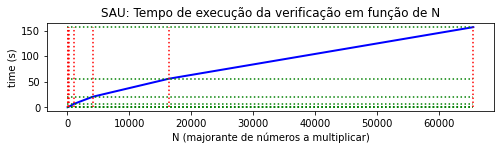

In [70]:
draw('b', times)

# Misc

In [26]:
def test():
    solver =  Solver()
    a = Symbol('a', BVType(16))
    b = Symbol('b', BVType(16))
    solver.add_assertion(GE(BVToNatural(BVAdd(a, b)), Int(56)))
    solver.add_assertion(Equals(BVAnd(a, BVOne(word_len)), BVSub(SBV(1, word_len), SBV(-1, word_len))))
    solver.add_assertion(Not(Equals(a, SBV(0, word_len))))
    # assertion 1: a = b
    res = solver.solve() # SAT (res == True)
    if res:
        print(solver.get_model())
        print('value a: {}'.format(solver.get_value(a)))
        print('value b: {}'.format(solver.get_value(b)))
test()

In [27]:
def test2():
    solver =  Solver()
    a = Symbol('a', BVType(16))
    b = Symbol('b', BVType(16))
    solver.add_assertion(Equals(BVSub(a, SBV(-1, word_len)), SBV(-2243, word_len)))
    # assertion 1: a = b
    res = solver.solve() # SAT (res == True)
    if res:
        print(solver.get_model())
        print('value a: {}'.format(solver.get_value(a)))
        print('value b: {}'.format(solver.get_value(b)))
test2()

a := 63292_16
value a: 63292_16
value b: 0_16


In [28]:
def test3():
    solver =  Solver()
    x = Symbol('x', INT)
    y = Symbol('y', INT)
    z = Symbol('z', INT)
    solver.add_assertion(Equals(x + y - z, Int(4353452)))
    solver.add_assertion(NotEquals(x, Int(0)))
    solver.add_assertion(NotEquals(y, Int(0)))
    solver.add_assertion(NotEquals(z, Int(0)))
    # assertion 1: a = b
    res = solver.solve() # SAT (res == True)
    if res:
        print(solver.get_model())
test3()

z := 1
y := -1
x := 4353454


In [64]:
def test4():
    solver =  Solver()
    solver.reset_assertions()
    x = Symbol('x', INT)
    y = Symbol('y', INT)
    z = Symbol('z', INT)
    solver.add_assertion(Equals(Plus(Plus(x, y), z), Int(123392753)))
    solver.add_assertion(NotEquals(x, Int(0)))
    solver.add_assertion(NotEquals(y, Int(0)))
    solver.add_assertion(NotEquals(z, Int(0)))
    solver.add_assertion(Not(Equals(x, y)))
    solver.add_assertion(Not(Equals(y, z)))
    solver.add_assertion(Not(Equals(x, z)))
    # assertion 1: a = b
    res = solver.solve() # SAT (res == True)
    if res:
        print(solver.get_model())
test4()

z := -1
y := -2
x := 123392756


In [42]:
def test5():
    solver =  Solver()
    a = Symbol('a', BVType(16))
    solver.add_assertion(NotEquals(a, BVZero(word_len)))
    solver.add_assertion(NotEquals(a, BV(65535, word_len)))
    prop = ForAll([a], Implies(NotEquals(a, BVZero(word_len)), NotEquals(BVToNatural(a), Int(0))))
    solver.add_assertion(prop)
    res = solver.solve() # SAT (res == True)
    if res:
        print(solver.get_model())
        print('value a: {}'.format(solver.get_value(a)))
    else:
        print("Unsat!")
test5()

a := 1_16
value a: 1_16


In [4]:
format(45, 'b')

'101101'

In [13]:
n = 59824
from math import log2
log2(n)

15.868436755858168

In [14]:
len(format(n, 'b'))

16